In [258]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [2]:
home = 0
if home:
    infiledir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\Processed_2"
    rand_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis"
    
else:
    infiledir = r"P:\EW_analysis\analysis\Processed_2"
    rand_dir = r"P:\EW_analysis\analysis"
    writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"

utils

In [257]:
class Data_Explorer:
    def __init__(self, response_var):
        self.response_name = response_var
    
    def nan_ids(self,in_df):
        self.response_vals = in_df[self.response_name]
        self.nan_ids = in_df.loc[in_df[self.response_name].isna(),'id'].values
    
    def zero_ids(self, in_df):
        self.zero_ids = in_df.loc[in_df[self.response_name]==0, 'id'].unique()
        self.zero_groups = in_df.loc[in_df.id.isin(self.zero_ids),'Group'].value_counts()
    
    
    def visualize_dist(self, distribution = None):
        if not distribution:
            self.distribution = 'normal'
        else:
            self.distribution = distribution


        if self.distribution == 'normal':
            fig = sm.qqplot(self.response_vals,line = 'q')
            fig.show()
        else:
            fig = sm.qqplot(self.response_vals,dist = stats.gamma,distargs = (4,),line = 'q')
            fig.show()
    
    def draw_kdeplot(self,in_df,names,colors,group_col):
        for i,session in enumerate(in_df[group_col].unique()):
            fig = sns.kdeplot(in_df.loc[in_df[group_col] == session, self.response_name],color = colors[i] )
        plt.legend(names)
    
    def draw_mean_trajectories(self,in_df,time_col):
        fig_mean, ax = plt.subplots(figsize=(6, 6))
        fig_mean = interaction_plot(
        x=in_df[time_col],
        trace=in_df.Group,
        response=in_df[self.response_name],
        colors=["red", "blue","black"],
        markers=["D", "^",'x'],
        ms=10,
        ax=ax,
        )

def check_normality(data_to_check):
    """ 
    Perform Anderson-Darling test to check normality.
    H0: The data follow a normal distribution.
    Critical values are for the following significance levels:
    15%, 10%, 5%, 2.5%, 1%

    Parameters
    ----------
    data_to_check:  array-like
        data to perform normality test on.
    
    """
    res = stats.anderson(data_to_check)
    sig, crit = res.significance_level,res.critical_values
    for i in range(len(sig)):
        if res.statistic<sig[i]:
            print(f'{sig[i],crit[i]}The data follow the specified distribution: failed to reject H0.')
        else:
            print(f'{sig[i],crit[i]} The data do not follow the specified distribution: H0 rejected.')

def model_checks(data_df, columns_to_use, y_to_use,model_res, mod_type):
    """
    Model diagnostics

    Parameters
    ----------
    data_df:    pandas DataFrame
        input dataframe
    columns_to_use: str
        names of columns containing predictors to be used in the analysis
    y_to_use:   str
        names of outcome column
    model_res:    
        statsmodel results
    mod_type:   str
        modelling approach used (eg LMM, GEE)

    -------
    """
    mod_res_df = data_df.loc[:,columns_to_use]
    drop_inds = mod_res_df.loc[mod_res_df[y_to_use].isna(),:].index.values
    mod_res_df = mod_res_df.drop(labels = drop_inds, axis = 0)
    mod_res_df['fitted'] = model_res.fittedvalues
    if mod_type == 'GEE':
        mod_res_df['residuals'] = model_res.resid_deviance
        a = mod_res_df.residuals.values
        a.sort()

        # half normal plot
        fig = plt.figure()
        res = stats.probplot(a,dist = stats.halfnorm,sparams = (-0.18,10), plot=plt)
        plt.show()
        g = sns.lmplot(x = "day", y = "residuals", hue = "Group", data = mod_res_df)
        g = (g.set_axis_labels("Day [#]", "Residuals"))

    else:
        mod_res_df['residuals'] = model_res.resid
        # qq plot:
        fig = sm.qqplot(mod_res_df.residuals)

    # plotting fitted against residuals
    g = sns.lmplot(x = "fitted", y = "residuals", hue = "Group", data = mod_res_df)
    g = (g.set_axis_labels("Predicted score", "Residuals"))


def scale_scores(in_df, col_names, scaler_type):
    """ 
    Scale questionnaire scores.

    Parameters
    ----------
    in_df:  pandas Dataframe
        Dataframe to operate on.
    col_names:  list
        list of column names to operate on.
    scaler_type:  
        sklearn scaler to use (e.g. StandardScaler())
    """
    scaler = scaler_type
    for col in col_names:
        in_df[col+'_scaled'] = scaler.fit_transform(in_df[col].values.reshape(-1,1))


In [117]:
writing_df = pd.read_csv(os.path.join(writing_dir, 'writing_df.csv'))
mcq_df = writing_df.iloc[:,31:-5]
#mcq_df = writing_df.filter(regex = re.compile('my memory',re.IGNORECASE),axis = 1)

mcq_key = ['memory_dim_clear', 'visual_details','vivid',
            'memory_sketch_clear','order_events_confusing_clear','remember_hardly_vwell',
            'involves_sounds','involves_touch','involves_taste','involves_smell','location_clear_vague',
            'spatial_arrangement_objects','spatial_arrangement_people','memory_time_vague_clear']

mcq_df.columns = mcq_key
print(mcq_df.columns)
mcq_df['id'] = writing_df.id
mcq_df['day'] = writing_df.day

Index(['memory_dim_clear', 'visual_details', 'vivid', 'memory_sketch_clear',
       'order_events_confusing_clear', 'remember_hardly_vwell',
       'involves_sounds', 'involves_touch', 'involves_taste', 'involves_smell',
       'location_clear_vague', 'spatial_arrangement_objects',
       'spatial_arrangement_people', 'memory_time_vague_clear'],
      dtype='object')


In [126]:
# get total score for each participant/day
tot_score_df = mcq_df.set_index(['id','day']).sum(axis = 1)
# revert back to 'regular' index bc it's easier to work with:
tot_score_df = tot_score_df.reset_index()
tot_score_df = tot_score_df.rename( columns = {0:'mcq_total'})

In [145]:
tot_score_df['Group'] = np.nan
for group in writing_df.Group.unique():
    group_ids = writing_df.loc[writing_df.Group == group, 'id'].unique()
    tot_score_df.loc[tot_score_df.id.isin(group_ids),'Group'] = group


Data exploration

<ipython-input-169-e2f740f9ea88>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


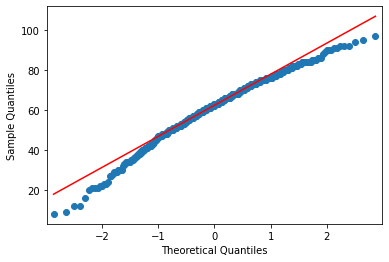

In [170]:
dt = Data_Explorer('mcq_total')
dt.nan_ids(tot_score_df)    
dt.zero_ids(tot_score_df)
dt.visualize_dist(distribution = 'normal')

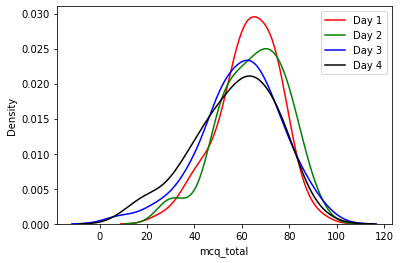

In [167]:
dt.draw_kdeplot(tot_score_df,['Day 1','Day 2','Day 3', 'Day 4'],['r','g','b','k'], 'day')

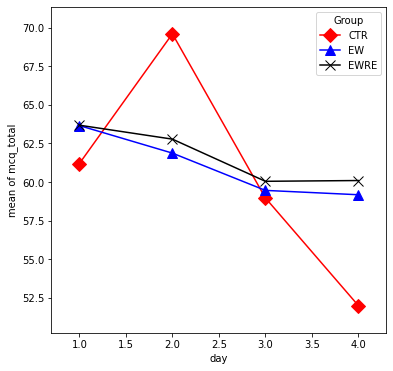

In [172]:
dt.draw_mean_trajectories(tot_score_df,'day')

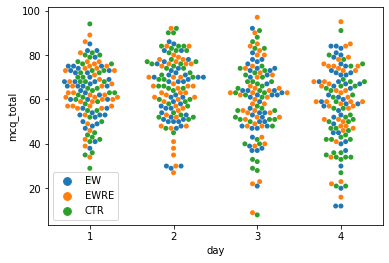

In [ ]:
sns.swarmplot(x = tot_score_df.day, y = tot_score_df.mcq_total, hue = tot_score_df.Group)
plt.legend(loc = 'lower left')


In [182]:
# check normality
check_normality(tot_score_df.mcq_total)

(15.0, 0.571)The data follow the specified distribution: failed to reject H0.
(10.0, 0.651)The data follow the specified distribution: failed to reject H0.
(5.0, 0.781)The data follow the specified distribution: failed to reject H0.
(2.5, 0.911)The data follow the specified distribution: failed to reject H0.
(1.0, 1.083) The data do not follow the specified distribution: H0 rejected.


Modelling

In [208]:
# make 'active' group (i.e. consisting of EW + EWRE):
tot_score_df['Group_act_v_ctr'] = tot_score_df.Group.replace('EWRE','EW')
print(tot_score_df.Group_act_v_ctr.value_counts())
print(tot_score_df.Group.value_counts())

EW     321
CTR    160
Name: Group_act_v_ctr, dtype: int64
EWRE    162
CTR     160
EW      159
Name: Group, dtype: int64


In [243]:
# use linear mixed effects model, conditional and interaction effects
model_mcq = smf.mixedlm("mcq_total ~ C(day,Treatment(1)) * C(Group, Treatment('CTR'))", tot_score_df, groups=tot_score_df['id']).fit()

In [244]:
model_mcq.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Mixed Linear Model Regression Results
=========================================================================================================
Model:                             MixedLM                 Dependent Variable:                 mcq_total 
No. Observations:                  481                     Method:                             REML      
No. Groups:                        122                     Scale:                              121.2610  
Min. group size:                   1                       Log-Likelihood:                     -1908.0206
Max. group size:                   4                       Converged:                          Yes       
Mean group size:                   3.9                                                                   
---------------------------------------------------------------------------------------------------------
                                                              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                                     61.200    2.469 24.791 0.000  56.362 66.038
C(day, Treatment(1))[T.2]                                      8.400    2.462  3.411 0.001   3.574 13.226
C(day, Treatment(1))[T.3]                                     -2.225    2.462 -0.904 0.366  -7.051  2.601
C(day, Treatment(1))[T.4]                                     -9.200    2.462 -3.736 0.000 -14.026 -4.374
C(Group, Treatment('CTR'))[T.EW]                               2.459    3.470  0.709 0.479  -4.342  9.259
C(Group, Treatment('CTR'))[T.EWRE]                             2.483    3.470  0.716 0.474  -4.318  9.284
C(day, Treatment(1))[T.2]:C(Group, Treatment('CTR'))[T.EW]   -10.280    3.477 -2.957 0.003 -17.095 -3.465
C(day, Treatment(1))[T.3]:C(Group, Treatment('CTR'))[T.EW]    -1.680    3.492 -0.481 0.630  -8.524  5.164
C(day, Treatment(1))[T.4]:C(Group, Treatment('CTR'))[T.EW]     5.013    3.492  1.436 0.151  -1.831 11.857
C(day, Treatment(1))[T.2]:C(Group, Treatment('CTR'))[T.EWRE]  -9.302    3.461 -2.688 0.007 -16.086 -2.519
C(day, Treatment(1))[T.3]:C(Group, Treatment('CTR'))[T.EWRE]  -1.328    3.475 -0.382 0.702  -8.139  5.483
C(day, Treatment(1))[T.4]:C(Group, Treatment('CTR'))[T.EWRE]   5.697    3.475  1.639 0.101  -1.114 12.508
Group Var                                                    122.503    2.092                            
=========================================================================================================

"""

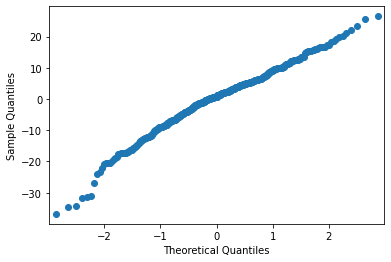

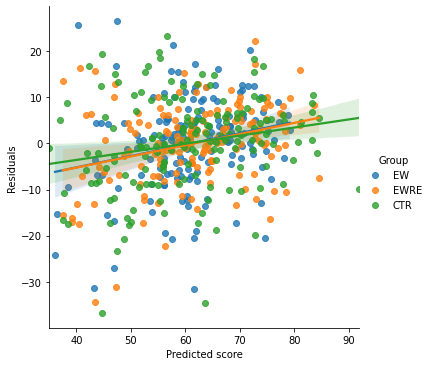

In [245]:
model_checks(tot_score_df,tot_score_df.columns,'mcq_total',model_mcq,'LMM')

In [255]:
all_dat_df = pd.read_csv(os.path.join(infiledir, 'all_dat_df.csv')) # read in data
moderator_df = all_dat_df.loc[(all_dat_df.order == 1),['ADNM_burden_total','dass_depression','dass_anxiety','dass_stress','ERQ_reapp','ERQ_sup','RRS_total','id']]

In [259]:
scale_scores(moderator_df, moderator_df.columns, StandardScaler())
print(moderator_df.head())

In [276]:
moderator_df = moderator_df.set_index('id')
tot_score_df = tot_score_df.set_index('id')
tot_score_df = tot_score_df.loc[moderator_df.index,:]
for col_name in moderator_df.filter(like = '_scaled',axis = 1).columns:
    tot_score_df[col_name] = moderator_df.loc[tot_score_df.index,col_name]
tot_score_df = tot_score_df.reset_index()

In [292]:
model_mcq_ADNM_base = smf.mixedlm("mcq_total ~ C(day,Treatment(1)) * C(Group, Treatment('CTR'))*RRS_total_scaled", tot_score_df, groups=tot_score_df['id']).fit()

In [293]:
model_mcq_ADNM_base.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                          Mixed Linear Model Regression Results
==========================================================================================================================
Model:                                  MixedLM                       Dependent Variable:                       mcq_total 
No. Observations:                       476                           Method:                                   REML      
No. Groups:                             119                           Scale:                                    121.3653  
Min. group size:                        4                             Log-Likelihood:                           -1861.2953
Max. group size:                        4                             Converged:                                Yes       
Mean group size:                        4.0                                                                               
--------------------------------------------------------------------------------------------------------------------------
                                                                               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      60.983    2.472 24.670 0.000  56.138 65.828
C(day, Treatment(1))[T.2]                                                       8.512    2.466  3.451 0.001   3.678 13.346
C(day, Treatment(1))[T.3]                                                      -2.100    2.466 -0.852 0.394  -6.934  2.734
C(day, Treatment(1))[T.4]                                                      -8.895    2.466 -3.607 0.000 -13.729 -4.061
C(Group, Treatment('CTR'))[T.EW]                                                2.464    3.522  0.700 0.484  -4.438  9.367
C(Group, Treatment('CTR'))[T.EWRE]                                              2.790    3.512  0.794 0.427  -4.093  9.674
C(day, Treatment(1))[T.2]:C(Group, Treatment('CTR'))[T.EW]                    -10.421    3.514 -2.966 0.003 -17.308 -3.535
C(day, Treatment(1))[T.3]:C(Group, Treatment('CTR'))[T.EW]                     -1.650    3.514 -0.469 0.639  -8.536  5.237
C(day, Treatment(1))[T.4]:C(Group, Treatment('CTR'))[T.EW]                      4.835    3.514  1.376 0.169  -2.052 11.722
C(day, Treatment(1))[T.2]:C(Group, Treatment('CTR'))[T.EWRE]                   -9.372    3.504 -2.675 0.007 -16.240 -2.504
C(day, Treatment(1))[T.3]:C(Group, Treatment('CTR'))[T.EWRE]                   -1.510    3.504 -0.431 0.667  -8.378  5.358
C(day, Treatment(1))[T.4]:C(Group, Treatment('CTR'))[T.EWRE]                    4.873    3.504  1.391 0.164  -1.995 11.741
RRS_total_scaled                                                               -4.561    2.518 -1.811 0.070  -9.497  0.375
C(day, Treatment(1))[T.2]:RRS_total_scaled                                      2.355    2.513  0.937 0.349  -2.569  7.280
C(day, Treatment(1))[T.3]:RRS_total_scaled                                      2.624    2.513  1.044 0.296  -2.301  7.548
C(day, Treatment(1))[T.4]:RRS_total_scaled                                      6.401    2.513  2.548 0.011   1.477 11.326
C(Group, Treatment('CTR'))[T.EW]:RRS_total_scaled                               6.164    3.411  1.807 0.071  -0.522 12.850
C(Group, Treatment('CTR'))[T.EWRE]:RRS_total_scaled                             2.879    3.693  0.779 0.436  -4.360 10.118
C(day, Treatment(1))[T.2]:C(Group, Treatment('CTR'))[T.EW]:RRS_total_scaled    -0.723    3.403 -0.212 0.832  -7.394  5.948
C(day, Treatment(1))[T.3]:C(Group, Treatment('CTR'))[T.EW]:RRS_total_scaled    -1.516    3.403 -0.445 0.656  -8.186  5.155
C(day, Treatment(1))[T.4]:C(Group, Treatment('CTR'))[T.EW]:RRS_total_scaled    -5.618    3.403 -1.651 0.099 -12.289  1.053
C(day, Treatment(1))[T.2]:C(Group, Treatment('CTR'))[T.EWR